In [ ]:
import os
os.chdir('../')

In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [2]:
torch.cuda.set_device(2)

In [3]:
dls_feat = get_3d_dls_feat(Meta.df_comb, path=path_feat_384avg, bs=32)

## Model

In [4]:
xb, yb = dls_feat.one_batch(); xb.shape

torch.Size([32, 60, 512, 8, 8])

In [5]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
class LinHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 1024
        self.flat = nn.Sequential(AdaptiveConcatPool2d(), Flatten())
        self.hook = ReshapeBodyHook(self.flat)
        self.head = nn.Sequential(nn.Linear(d_model,6))
        
    def forward(self, x):
        x = self.flat(x)
        return self.head(x)

In [6]:
m = LinHead()
name = 'train3d_baseline_feat_linear'
learn = get_learner(dls_feat, m, name=name)
learn.add_cb(DePadLoss())

In [7]:
xb.shape

torch.Size([32, 60, 512, 8, 8])

In [11]:
# with torch.no_grad():
#     learn.model(xb).shape

In [12]:
# learn.summary()

## Training

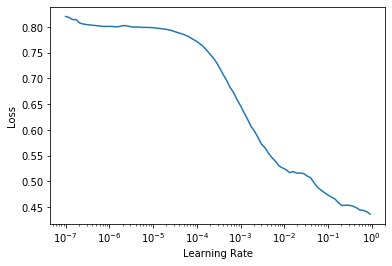

In [13]:
learn.lr_find()

In [14]:
do_fit(learn, 10, 1e-3)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.089308,0.093898,0.969983,0.948106,01:17
1,0.061074,0.080245,0.975144,0.952269,01:16
2,0.062907,0.079827,0.975554,0.952117,01:16
3,0.058123,0.077155,0.976018,0.954727,01:17
4,0.057603,0.077597,0.975931,0.954688,01:17
5,0.059073,0.076831,0.976400,0.954319,01:17
6,0.059110,0.076568,0.976557,0.954765,01:17
7,0.056581,0.077009,0.976342,0.954166,01:17
8,0.055444,0.076774,0.976385,0.954217,01:17
9,0.056008,0.076591,0.976376,0.954485,01:18


## Testing

In [8]:
learn.dls = get_3d_dls_feat(Meta.df_tst, path=path_feat_tst_384avg, bs=32, test=True)

In [9]:
sub_fn = f'subm/{name}'
learn.load(f'runs/{name}-1')

In [10]:
preds,targs = learn.get_preds()
preds.shape, preds.min(), preds.max()

(torch.Size([121232, 6]), tensor(1.5558e-09), tensor(1.0000))

In [11]:
pred_csv = submission(Meta.df_tst, preds, fn=sub_fn)

In [12]:
api.competition_submit(f'{sub_fn}.csv', name, 'rsna-intracranial-hemorrhage-detection')

100%|██████████| 26.0M/26.0M [00:02<00:00, 11.0MB/s]


Successfully submitted to RSNA Intracranial Hemorrhage Detection

In [13]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14345893,
 'totalBytes': 27277209,
 'date': '2020-01-31T20:34:30.767Z',
 'description': 'train3d_baseline_feat_linear',
 'errorDescription': None,
 'fileName': 'train3d_baseline_feat_linear.csv',
 'publicScore': '0.89054',
 'privateScore': '0.06416',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14345893/14345893.raw'}